In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
from matplotlib.dates import date2num
from utide import solve, reconstruct
import numpy as np
import pandas as pd
from windrose import WindroseAxes
import scipy as sp
import hvplot.xarray
from eofs.xarray import Eof
import glob

## Read velocity

In [3]:
files=sorted(glob.glob('GOM/new_5km-radius/GOM-1-*2012*'))
files

['GOM/new_5km-radius/GOM-1-2012-01.nc',
 'GOM/new_5km-radius/GOM-1-2012-02.nc',
 'GOM/new_5km-radius/GOM-1-2012-03.nc',
 'GOM/new_5km-radius/GOM-1-2012-04.nc',
 'GOM/new_5km-radius/GOM-1-2012-05.nc',
 'GOM/new_5km-radius/GOM-1-2012-06.nc',
 'GOM/new_5km-radius/GOM-1-2012-07.nc',
 'GOM/new_5km-radius/GOM-1-2012-08.nc',
 'GOM/new_5km-radius/GOM-1-2012-09.nc',
 'GOM/new_5km-radius/GOM-1-2012-10.nc',
 'GOM/new_5km-radius/GOM-1-2012-11.nc',
 'GOM/new_5km-radius/GOM-1-2012-12.nc']

Using only one file:

In [4]:
vel=[]
for file in files:
    tmp=xr.open_dataset(file).load()
    tmp.close()
    vel.append(tmp)

vel=xr.concat(vel, dim='ocean_time')
vel['lon']=vel.lon.mean(dim='ocean_time')
vel['lat']=vel.lat.mean(dim='ocean_time')
vel['z']=vel.z.mean(dim='ocean_time')

vel=vel.set_coords(('lon','lat','z'))
vel

<xarray.Dataset>
Dimensions:     (ocean_time: 8784, node: 23, depth: 30)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2012-01-01T01:00:00 ... 2013-01-01
    lon         (node) float64 -94.13 -94.16 -94.13 ... -94.18 -94.15 -94.13
    lat         (node) float64 29.52 29.53 29.54 29.54 ... 29.6 29.6 29.6 29.61
    z           (depth, node) float64 -12.45 -12.0 -11.68 ... -0.1291 -0.1256
Dimensions without coordinates: node, depth
Data variables:
    temp        (ocean_time, depth, node) float64 16.57 16.58 ... 14.47 14.48
    salt        (ocean_time, depth, node) float64 29.19 29.36 ... 30.6 30.57
    w           (ocean_time, depth, node) float64 4.346e-06 ... 3.179e-07
    u           (ocean_time, depth, node) float64 -0.006107 ... -0.0975
    v           (ocean_time, depth, node) float64 0.004908 0.01094 ... 0.05773
Attributes: (12/33)
    file:              /scratch/user/d.kobashi/projects/hindcasts/projects/tx...
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             Texas-Louisiana shelf hindcast with dyes
    var_info:          varinfo.dat
    ...                ...
    compiler_flags:    -fp-model fast -heap-arrays -ip -O3
    tiling:            010x012
    ana_file:          /scratch/user/d.kobashi/source_code/COAWST/Functionals...
    CPP_options:       TXLA2, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_SPFLUX,...
    history:           Sun Feb 20 15:39:41 2022: ncrename -v depth,z 5km-radi...
    NCO:               netCDF Operators version 5.0.6 (Homepage = http://nco....

In [6]:
vel.ocean_time.sortby('ocean_time').diff(dim='ocean_time').max()

<xarray.DataArray 'ocean_time' ()>
array(3600000000000, dtype='timedelta64[ns]')

In [7]:
tmp=vel.mean(dim='depth').mean(dim='ocean_time')
tmp

<xarray.Dataset>
Dimensions:  (node: 23)
Coordinates:
    lon      (node) float64 -94.13 -94.16 -94.13 -94.11 ... -94.18 -94.15 -94.13
    lat      (node) float64 29.52 29.53 29.54 29.54 ... 29.6 29.6 29.6 29.61
Dimensions without coordinates: node
Data variables:
    temp     (node) float64 24.36 24.36 24.36 24.36 ... 24.35 24.37 24.37 24.35
    salt     (node) float64 29.42 29.35 29.3 29.24 ... 28.57 28.42 28.39 28.41
    w        (node) float64 -5.42e-06 -3.175e-06 ... 4.397e-07 -2.903e-06
    u        (node) float64 -0.004325 -0.004186 -0.003309 ... -0.02248 -0.02079
    v        (node) float64 0.0008546 0.0005162 -0.000245 ... -0.00806 -0.001727

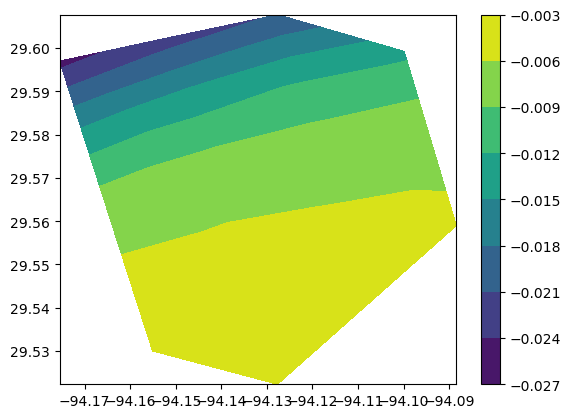

In [8]:
plt.tricontourf(tmp.lon,tmp.lat,tmp.u)
plt.colorbar()

In [13]:


from numpy.random import seed
from numpy.random import randint
seed(1)


def one_particle(vel,steps=200,num=1):

## This function use the velocity field and move one particle based on random selection of depth and node and starting time in the timeseries.

    sizes=vel.sizes
    node=randint(0,sizes['node'],1)
    depth=randint(0,sizes['depth'],1)
    start=randint(0,sizes['ocean_time']-steps,1)
    time=vel.ocean_time.isel(ocean_time=start+np.arange(steps))
    time=(time.data-time[0].data)/np.timedelta64(1,'h')

    

    tmpx=np.zeros(steps)
    tmpy=np.zeros(steps)
    
    for ii in np.arange(steps):
        tmpy[ii]=vel.isel(ocean_time= start+np.arange(ii+1),node=node,depth=depth).v.integrate(coord='ocean_time',datetime_unit='s')
        tmpx[ii]=vel.isel(ocean_time= start+np.arange(ii+1),node=node,depth=depth).u.integrate(coord='ocean_time',datetime_unit='s')
    
    
    particle=xr.Dataset(
    {
        "nodes": (["num"], node),
        "depths": (["num"], depth),
        "start": (["num"], start),
        "x":(["time"],tmpx),
        "y":(["time"],tmpy),
        "time":(["time"], time)
        },
        coords={"num": [num],
        
        })
    particle['r']=(('time',np.sqrt(particle.x.data**2+particle.y.data**2)))
    #particle['time']=time


    

    return particle

In [14]:
time=vel.ocean_time.isel(ocean_time=10+np.arange(12))
time.data-time[0].data

array([             0,  3600000000000,  7200000000000, 10800000000000,
       14400000000000, 18000000000000, 21600000000000, 25200000000000,
       28800000000000, 32400000000000, 36000000000000, 39600000000000],
      dtype='timedelta64[ns]')

In [15]:
num=500 # Number of particles to release
steps=50 # Number of time steps of one hour.

particles=[]
for ii in np.arange(num):
    particles.append(one_particle(vel,steps,num=ii))

particles=xr.concat(particles,dim='num')
#particles #uncomment to to see the results. 

In [16]:
particles

<xarray.Dataset>
Dimensions:  (num: 500, time: 50)
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 45.0 46.0 47.0 48.0 49.0
  * num      (num) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    nodes    (num) int64 5 9 15 1 13 18 5 11 14 9 ... 20 14 15 10 19 3 4 22 21 6
    depths   (num) int64 11 11 0 12 28 20 18 28 18 ... 14 27 14 18 17 5 29 16 6
    start    (num) int64 5192 7813 144 7751 3462 ... 6361 8680 4603 1864 6648
    x        (num, time) float64 0.0 152.2 297.7 ... -1.057e+04 -1.082e+04
    y        (num, time) float64 0.0 -27.52 -58.22 ... -2.094e+03 -2.122e+03
    r        (num, time) float64 0.0 154.7 303.4 ... 1.077e+04 1.103e+04

Some figures. 

(-31424.500475158384,
 28704.627430912995,
 -12535.05195014601,
 10024.258264179505)

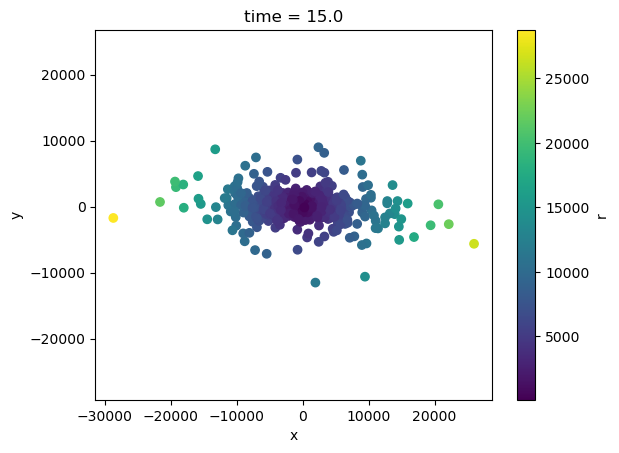

In [17]:
itime=15
particles.isel(time=itime).plot.scatter(x='x',y='y',hue='r')
plt.axis('equal')

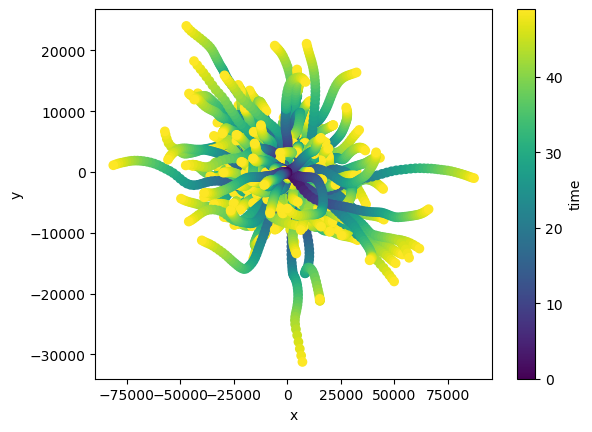

In [18]:
particles.plot.scatter(x='x',y='y',hue='time')


In [41]:
particles

<xarray.Dataset>
Dimensions:  (r: 24501, num: 500, time: 50)
Coordinates:
  * r        (r) float64 0.0 16.26 18.84 20.73 ... 6.31e+04 6.355e+04 6.485e+04
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 45.0 46.0 47.0 48.0 49.0
  * num      (num) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    nodes    (num) int64 5 9 15 1 13 18 5 11 14 9 0 ... 4 2 12 18 1 3 11 7 20 11
    depths   (num) int64 11 11 0 12 28 20 18 28 18 ... 27 3 19 0 24 12 16 8 19
    start    (num) int64 72 645 144 583 390 254 468 ... 265 550 171 608 664 266
    x        (num, time) float64 0.0 513.2 1.061e+03 ... 5.091e+03 5.264e+03
    y        (num, time) float64 0.0 -168.1 -322.8 ... -3.533e+03 -3.28e+03

In [19]:
particles.isel(time=itime)

<xarray.Dataset>
Dimensions:  (num: 500)
Coordinates:
    time     float64 15.0
  * num      (num) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    nodes    (num) int64 5 9 15 1 13 18 5 11 14 9 ... 20 14 15 10 19 3 4 22 21 6
    depths   (num) int64 11 11 0 12 28 20 18 28 18 ... 14 27 14 18 17 5 29 16 6
    start    (num) int64 5192 7813 144 7751 3462 ... 6361 8680 4603 1864 6648
    x        (num) float64 2.057e+03 2.145e+03 -307.4 ... -1.033e+04 -3.302e+03
    y        (num) float64 -450.5 148.6 687.6 729.0 ... 1.846e+03 -689.3 -537.0
    r        (num) float64 2.106e+03 2.15e+03 753.1 ... 1.036e+04 3.345e+03

## Quantiles as function of time

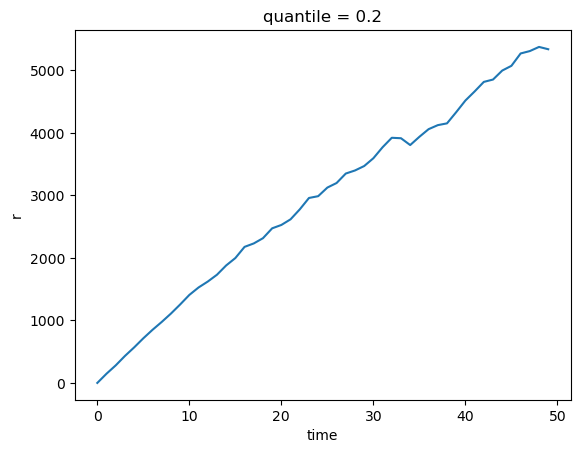

In [127]:
particles.r.quantile(0.2,dim='num').plot()

## Estimates of density. 
Adjusting for larger radius, 

Radius if a ring with inner radius $r_0$ and outer radius $r_0+\delta$ using $\delta=1$.
$$ A =\pi \delta (2r_0+\delta)$$

In [102]:
delR=100 # The thickness of the rings
num_bins=20 #number of bins
r_bins=np.append([5,10,20,30,50], (1+np.arange(num_bins))*delR)

r_bins


array([   5,   10,   20,   30,   50,  100,  200,  300,  400,  500,  600,
        700,  800,  900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700,
       1800, 1900, 2000])

In [123]:
particles

<xarray.Dataset>
Dimensions:  (num: 500, time: 50)
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 45.0 46.0 47.0 48.0 49.0
  * num      (num) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    nodes    (num) int64 5 9 15 1 13 18 5 11 14 9 ... 20 14 15 10 19 3 4 22 21 6
    depths   (num) int64 11 11 0 12 28 20 18 28 18 ... 14 27 14 18 17 5 29 16 6
    start    (num) int64 5192 7813 144 7751 3462 ... 6361 8680 4603 1864 6648
    x        (num, time) float64 0.0 152.2 297.7 ... -1.057e+04 -1.082e+04
    y        (num, time) float64 0.0 -27.52 -58.22 ... -2.094e+03 -2.122e+03
    r        (num, time) float64 0.0 154.7 303.4 ... 1.077e+04 1.103e+04
    con      (num, time) float64 3.183e-05 7.776e-06 ... 1.47e-07 1.437e-07
    A        (num, time) float64 1e+06 1.33e-05 ... 2.742e-09 2.618e-09

In [103]:
np.shape(1./(np.pi*delR*(2*particles.r.data+delR)))

(500, 50)

(array([1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        2., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 1., 2., 1., 2., 1., 1.,
        2., 1., 2., 1., 2., 2.]),
 array([    0.        ,   366.75191795,   733.5038359 ,  1100.25575384,
         1467.00767179,  1833.75958974,  2200.51150769,  2567.26342563,
         2934.01534358,  3300.76726153,  3667.51917948,  4034.27109743,
         4401.02301537,  4767.77493332,  5134.52685127,  5501.27876922,
         5868.03068717,  6234.78260511,  6601.53452306,  6968.28644101,
         7335.03835896,  7701.7902769 ,  8068.54219485,  8435.2941128 ,
         8802.04603075,  9168.7979487 ,  9535.54986664,  9902.30178459,
        10269.05370254, 10635.80562049, 11002.55753843, 11369.30945638,
        11736.06137433, 12102.81329228, 12469.56521023, 12836.31712817,
        13203.06904612, 13569.82096407, 13936.57288202, 14303.32479997,
        14670.07671791]),
 <BarContainer object of 40 artists>)

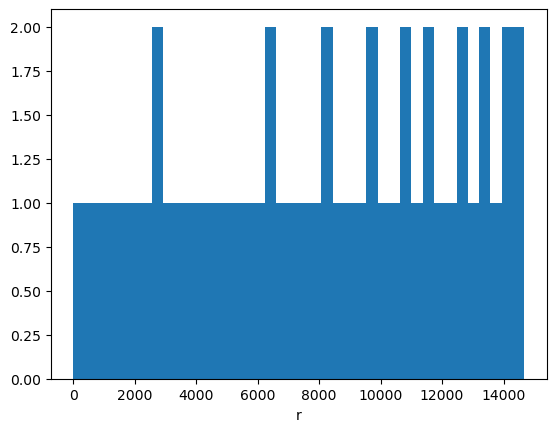

In [124]:
particles.r.mean(dim='num').plot.hist(bins=40)

In [105]:
particles['con']=((['num','time'],1./(np.pi*delR*(2*particles.r.data+delR)))) #Each particle contributes to density with 1/A.
#particles['A']=1./(np.pi*r_bins**2)
particles['A']=((['num','time'],1/(np.pi*particles.r.data**2+1e-6)))
particles

<xarray.Dataset>
Dimensions:  (num: 500, time: 50)
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 45.0 46.0 47.0 48.0 49.0
  * num      (num) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    nodes    (num) int64 5 9 15 1 13 18 5 11 14 9 ... 20 14 15 10 19 3 4 22 21 6
    depths   (num) int64 11 11 0 12 28 20 18 28 18 ... 14 27 14 18 17 5 29 16 6
    start    (num) int64 5192 7813 144 7751 3462 ... 6361 8680 4603 1864 6648
    x        (num, time) float64 0.0 152.2 297.7 ... -1.057e+04 -1.082e+04
    y        (num, time) float64 0.0 -27.52 -58.22 ... -2.094e+03 -2.122e+03
    r        (num, time) float64 0.0 154.7 303.4 ... 1.077e+04 1.103e+04
    con      (num, time) float64 3.183e-05 7.776e-06 ... 1.47e-07 1.437e-07
    A        (num, time) float64 1e+06 1.33e-05 ... 2.742e-09 2.618e-09

bins in radius.


In [106]:
cons=[]
for ii in np.arange(particles.sizes['time']):
    try:
        tmp=particles.isel(time=np.arange(ii)).groupby_bins('r',r_bins).sum().con
        #tmp=particles.isel(time=ii).groupby_bins('r',r_bins).sum().con
        tmp['time']=particles.isel(time=ii).time
    except:
        tmp=xr.zeros_like(particles.isel(time=1).groupby_bins('r',r_bins).sum().con)
        tmp['time']=ii
    cons.append(tmp)
cons=xr.concat(cons,dim='time')


In [107]:
cons

<xarray.DataArray 'con' (time: 50, r_bins: 24)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [           nan, 1.48623746e-04, 2.07289985e-05, ...,
                   nan,            nan, 7.94399084e-07],
       ...,
       [           nan, 1.74725814e-04, 1.05003427e-04, ...,
        2.05824787e-04, 1.95555986e-04, 1.90958334e-04],
       [           nan, 1.74725814e-04, 1.05003427e-04, ...,
        2.07593645e-04, 1.96403482e-04, 1.93361377e-04],
       [           nan, 1.74725814e-04, 1.05003427e-04, ...,
        2.08489496e-04, 2.00528940e-04, 1.94936021e-04]])
Coordinates:
  * r_bins   (r_bins) object (5, 10] (10, 20] ... (1800, 1900] (1900, 2000]
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 45.0 46.0 47.0 48.0 49.0

(1.0, 30.0)

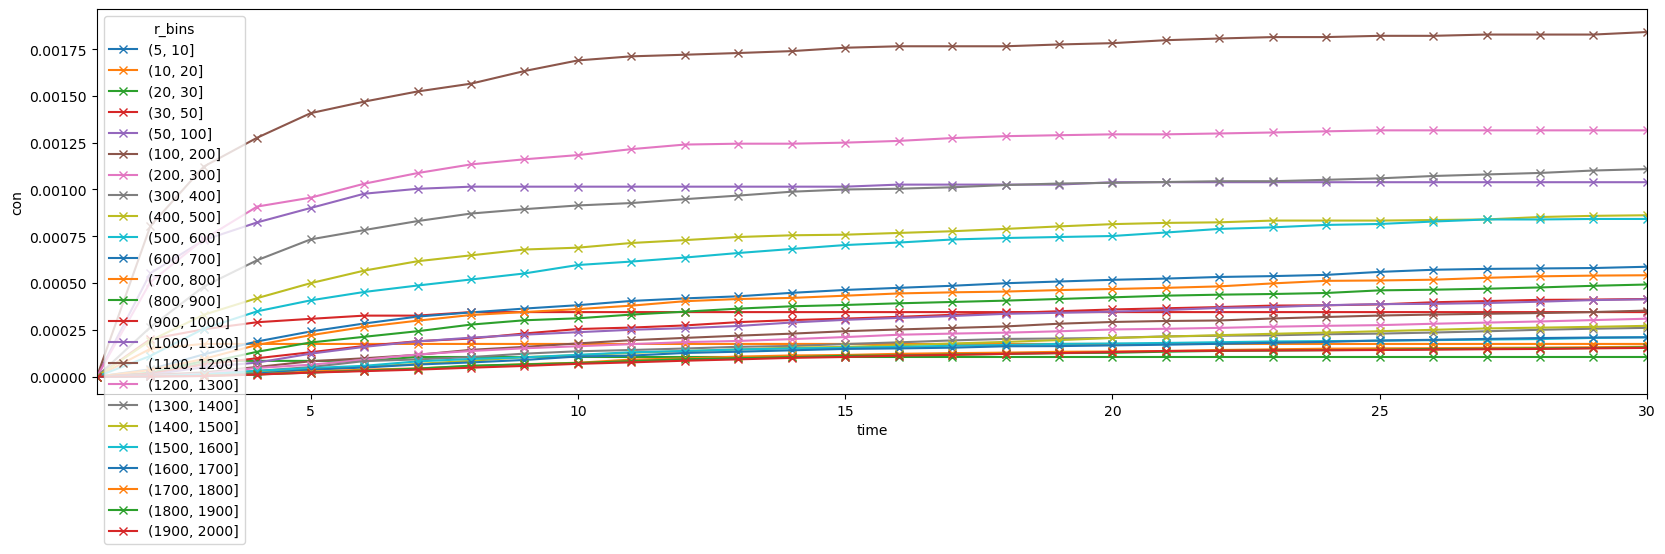

In [140]:
cons.plot.line(x='time',marker='x',aspect=4, size=5)
#plt.yscale('log')
plt.xlim(1,30)


In [143]:
cons

<xarray.DataArray 'con' (time: 50, r_bins: 24)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [           nan, 1.48623746e-04, 2.07289985e-05, ...,
                   nan,            nan, 7.94399084e-07],
       ...,
       [           nan, 1.74725814e-04, 1.05003427e-04, ...,
        2.05824787e-04, 1.95555986e-04, 1.90958334e-04],
       [           nan, 1.74725814e-04, 1.05003427e-04, ...,
        2.07593645e-04, 1.96403482e-04, 1.93361377e-04],
       [           nan, 1.74725814e-04, 1.05003427e-04, ...,
        2.08489496e-04, 2.00528940e-04, 1.94936021e-04]])
Coordinates:
  * r_bins   (r_bins) object (5, 10] (10, 20] ... (1800, 1900] (1900, 2000]
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 45.0 46.0 47.0 48.0 49.0

In [109]:
cons.r_bins

<xarray.DataArray 'r_bins' (r_bins: 24)>
array([Interval(5, 10, closed='right'), Interval(10, 20, closed='right'),
       Interval(20, 30, closed='right'), Interval(30, 50, closed='right'),
       Interval(50, 100, closed='right'), Interval(100, 200, closed='right'),
       Interval(200, 300, closed='right'), Interval(300, 400, closed='right'),
       Interval(400, 500, closed='right'), Interval(500, 600, closed='right'),
       Interval(600, 700, closed='right'), Interval(700, 800, closed='right'),
       Interval(800, 900, closed='right'), Interval(900, 1000, closed='right'),
       Interval(1000, 1100, closed='right'),
       Interval(1100, 1200, closed='right'),
       Interval(1200, 1300, closed='right'),
       Interval(1300, 1400, closed='right'),
       Interval(1400, 1500, closed='right'),
       Interval(1500, 1600, closed='right'),
       Interval(1600, 1700, closed='right'),
       Interval(1700, 1800, closed='right'),
       Interval(1800, 1900, closed='right'),
       Interval(1900, 2000, closed='right')], dtype=object)
Coordinates:
  * r_bins   (r_bins) object (5, 10] (10, 20] ... (1800, 1900] (1900, 2000]

In [110]:
r_bins

array([   5,   10,   20,   30,   50,  100,  200,  300,  400,  500,  600,
        700,  800,  900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700,
       1800, 1900, 2000])

In [111]:
rr=r_bins[0:-1]+np.diff(r_bins)/2
rr

array([   7.5,   15. ,   25. ,   40. ,   75. ,  150. ,  250. ,  350. ,
        450. ,  550. ,  650. ,  750. ,  850. ,  950. , 1050. , 1150. ,
       1250. , 1350. , 1450. , 1550. , 1650. , 1750. , 1850. , 1950. ])

In [144]:
cons=cons.assign_coords(rr=('r_bins',rr))

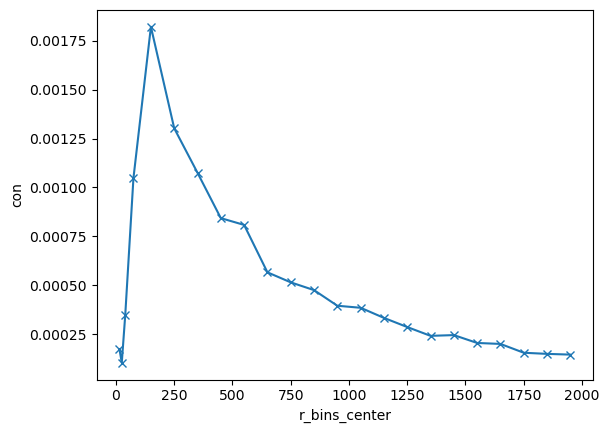

In [154]:
cons.isel(time=slice(10,49)).mean(dim='time').plot(marker='x')

/Users/guttorm/opt/anaconda3/envs/ocean/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


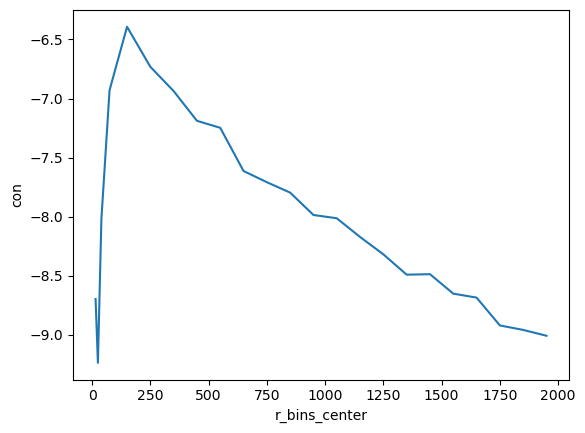

In [120]:
np.log(cons.mean(dim='time')).plot()

### To be continued...

In [129]:
temp=xr.open_dataset('GOM/temp.nc')

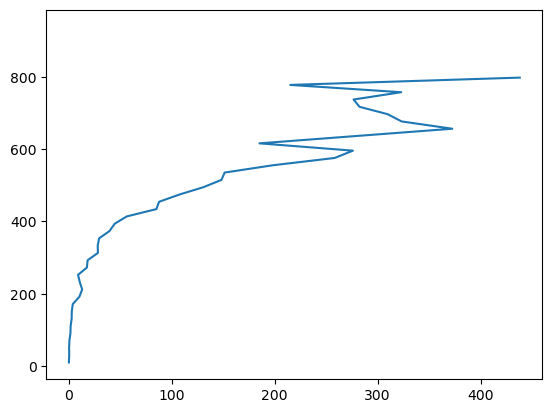

In [137]:
plt.plot(temp.time,temp.r)

In [5]:
test=xr.open_dataset('/home/guttorm/Github/ACTOM/Test_docker/Output/Sensor_locations.nc')
test

<xarray.Dataset>
Dimensions:        (sensor: 8, source: 50)
Coordinates:
  * sensor         (sensor) int64 1 2 3 4 5 6 7 8
  * source         (source) int64 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50
Data variables:
    x_sensor       (sensor) float64 ...
    y_sensor       (sensor) float64 ...
    ns_per_sensor  (sensor) int64 ...
    x_source       (source) float64 ...
    y_source       (source) float64 ...
    N_over         int64 ...

In [6]:
test.x_sensor

<xarray.DataArray 'x_sensor' (sensor: 8)>
array([-9103413.395323, -9099294.766339, -9098083.404873, -9100930.104318,
       -9100687.832025, -9101959.761564, -9097417.156067, -9097538.292214])
Coordinates:
  * sensor   (sensor) int64 1 2 3 4 5 6 7 8